## Installing necessary packages (this is google colab environment)

In [1]:
#!pip install --upgrade bitsandbytes
!pip install -q accelerate peft transformers trl datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 23.8 MB/s eta 0:00:00


In [2]:
!pip install bitsandbytes==0.41.1 #Google Colab comes with CUDA 12.4,bitsandbytes 0.41.1 (compatible with CUDA 12)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 12.5 MB/s eta 0:00:00


In [ ]:
#%pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 #transformers==4.48.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.15.2 requires accelerate>=0.34.0, but you have accelerate 0.21.0 which is incompatible.


In [5]:
import torch
print(torch.cuda.is_available())  # This should return True


False


In [19]:
import os

current_path = os.environ['PATH']

    # Split the PATH into individual directories
path_directories = current_path.split(':')

    # Filter out non-existent directories
valid_directories = [dir for dir in path_directories if os.path.exists(dir)]

    # Update the PATH variable
os.environ['PATH'] = ':'.join(valid_directories)

## Importing Necessary Libraries

In [6]:
import os
import numpy
import pandas
import torch
from datasets import load_dataset
from transformers import(
    AutoModelForCausalLM, #pretrained causal language model
    AutoTokenizer,     #
    BitsAndBytesConfig, #for configuring quantization
    HfArgumentParser, #cmd arguments
    TrainingArguments,
    pipeline,
    logging,
    GenerationConfig,
)
from peft import LoraConfig, PeftModel # Parameter efficient fine tuning and Low rank Adpation
from trl.trainer.sft_trainer import SFTTrainer #Supevised Fine tuning-SFT



/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


# We need data for fine tuning LLama2
LLama2 requires data to be of a specific prompt template(for chat models) :
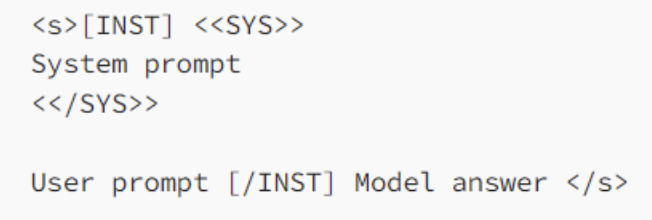

We will reformat our instruction dataset to follow Llama 2 template.
Orignal Dataset: https://huggingface.co/datasets/LDJnr/Puffin
Reformat Dataset following the Llama 2 template with 1k sample:
Complete Reformat Dataset following the Llama 2 template:

In [7]:
from datasets import load_dataset
import re

# Load the dataset
dataset = load_dataset('LDJnr/Puffin')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.70k [00:00<?, ?B/s]

Puffin.jsonl:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [10]:
#Puffin Dataset
for i in range(5):
  print(dataset["train"][i])

{'id': 1, 'conversations': [{'from': 'human', 'value': 'How do I center a text element vertically in a row in jetpack compose? The height of the row is determined by a button next to the text element.'}, {'from': 'gpt', 'value': 'In Jetpack Compose, you can center a text element vertically within a row by using the `Arrangement.Center` parameter for the `verticalAlignment` property in the `Row` composable. Here\'s an example:\n```kotlin\nimport androidx.compose.foundation.layout.Arrangement\nimport androidx.compose.foundation.layout.Row\nimport androidx.compose.material.Button\nimport androidx.compose.material.Text\nimport androidx.compose.runtime.Composable\nimport androidx.compose.ui.Alignment\n\n@Composable\nfun CenteredTextWithButton() {\n    Row(\n        verticalAlignment = Alignment.CenterVertically\n    ) {\n        Text("Centered Text")\n        Button(onClick = { /* Do something on button click */ }) {\n            Text("Button")\n        }\n    }\n}\n```\nIn this example, th

Transforming the dataset as per the requirments of LLAMA2 Format

In [24]:
def transform_conversation(example):
    conversations = example['conversations']
    formatted_conversation = []

    for i in range(len(conversations)):
        message = conversations[i]

        if message['from'] == 'human':
            # Human message starts the instruction
            instruction = message['value']
            if i + 1 < len(conversations) and conversations[i + 1]['from'] == 'gpt':
                # Pair Human message with GPT response
                response = conversations[i + 1]['value']
                formatted_conversation.append(f"<s>[INST] {instruction} [/INST] {response} </s>")

    # Join all turns into one long string
    return {'text': ' '.join(formatted_conversation)}

# Apply transformation to the dataset
transformed_dataset = dataset.map(transform_conversation)


In [26]:
def transform_conversation(example):
    reformatted_segments = []

    for convo in example["conversations"]:
        if convo["from"] == "human":
            reformatted_segments.append(f"<s>[INST] {convo['value']} [/INST]")
        elif convo["from"] == "gpt":
            reformatted_segments[-1] += f" {convo['value']} </s>"

    return {"text": " ".join(reformatted_segments)}

# Apply the transformation to the whole dataset
transformed_dataset = dataset.map(transform_conversation)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# Custom directory path inside Google Drive
save_path = "/content/drive/MyDrive/llama2_dataset"


In [27]:
transformed_dataset.save_to_disk(save_path)
print(f"Dataset saved to {save_path}")


Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset saved to /content/drive/MyDrive/llama2_dataset


In [29]:
for i in range(5):
  print(transformed_dataset["conversations"][i])

[{'from': 'human', 'value': "What is the expected decay signature in particle detectors for a W' or Z' boson with a mass of 2 TeV? How can this signature be distinguished from background noise and other signal processes?"}, {'from': 'gpt', 'value': "A W' or Z' boson with a mass of 2 TeV would be a heavy gauge boson, which is a hypothetical extension of the Standard Model of particle physics. These particles are expected to decay into various final states, depending on their couplings to other particles. The expected decay signatures in particle detectors for a W' or Z' boson with a mass of 2 TeV can be broadly classified into the following categories:\n\n1. Leptonic decays: The W' or Z' boson can decay into a charged lepton (electron, muon, or tau) and a neutrino (for W') or a pair of charged leptons (for Z'). These decays would produce a high transverse momentum (pT) lepton(s) and missing transverse energy (MET) due to the undetected neutrino(s).\n\n2. Hadronic decays: The W' or Z' bo

In [ ]:
 !pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip uninstall bitsandbytes

Found existing installation: bitsandbytes 0.45.2
Uninstalling bitsandbytes-0.45.2:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/bitsandbytes-0.45.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/bitsandbytes/*
Proceed (Y/n)? y
  Successfully uninstalled bitsandbytes-0.45.2


In [ ]:
!pip install -q -U bitsandbytes

In [ ]:
!pip install git+https://github.com/TimDettmers/bitsandbytes.git

  Cloning https://github.com/TimDettmers/bitsandbytes.git to /tmp/pip-req-build-1b7284t_
  Running command git clone --filter=blob:none --quiet https://github.com/TimDettmers/bitsandbytes.git /tmp/pip-req-build-1b7284t_
  Resolved https://github.com/TimDettmers/bitsandbytes.git to commit 8ed7d97b4901b4f01f9ac04262e3a34d1cb6941a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bitsandbytes: filename=bitsandbytes-0.45.3.dev0-cp311-cp311-linux_x86_64.whl size=90542 sha256=0d0ff80453c91ab94bf8a4990b8a14fb49891bb9de8def1ea78fcaef60d63407
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xykhabs/wheels/85/06/31/de7992855a6f6df8812a233c904db938c7a990eb338eadb41a
Successfully built bitsandbytes


In [ ]:
model_one = "meta-llama/Llama-2-7b-chat-hf" #accessed via meta on Huggingface : model_id = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(model_one)
model = AutoModelForCausalLM.from_pretrained(model_one, quantization_config=bnb_config, device_map={"":0})

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:

!pip install -U bitsandbytes

  Using cached bitsandbytes-0.45.2-py3-none-manylinux_2_24_x86_64.whl.metadata (5.8 kB)
Using cached bitsandbytes-0.45.2-py3-none-manylinux_2_24_x86_64.whl (69.7 MB)


# Lets do some traning setup

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    # target_modules=["query_key_value"],
    target_modules=["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj"], #specific to Llama models.
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Data Setup